# Test on Controllability and Robustness on Name Pair Task; Prediction on Last Name only; Train w/ Counterfactual

**input seq**: first_name_ctx has last name_ctx last_name [SEP] first_name has last name

**target seq**: last_name

- Training and Validation: first_name_ctx == first_name, last_name_ctx == last_name1  

- Counterfactual Testing: first_name_ctx == first_name, last_name_ctx != last_name 

- Counterfactual Irrelevant Testing: first_name_ctx != first_name, last_name_ctx != last_name 

- Counterfactual Irrelevant First Name Change Only Testing: first_name_ctx != first_name, last_name_ctx == last_name 

- Empty Context Testing: input  [SEP] first_name has last name, target last_name

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [2]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers
from seq2seq_models import Seq2SeqTransformer

## Config

In [3]:
args = argparse.Namespace(
    batch_size=32, n_epochs=40, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=2, n_heads=4, d_model=128, dff=128*4)

In [5]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Data

In [33]:
# get data and vocab for the first 200 samples
data_path = '../name_pairs_dataset/full-sentences.txt'
with open(data_path) as f:
    data = f.read().splitlines()[:200]
    last_names = [x.split(' ')[-1] for x in data]

with open('../name_pairs_dataset/first-names.txt') as f:
    first_names = f.read().splitlines()[:200]


# create vocab map
vocab = first_names + last_names
vocab = [x.lower() for x in vocab]
vocab += ['has', 'last', 'name', '[UNK]', '[sep]']
vocab = list(set(vocab))
vocab_map = {vocab: i for i, vocab in enumerate(vocab)}
vocab_size = len(vocab)
print('vocab size: ', vocab_size) # vocab size is very large; especially for a task this simple



# keep the same first name in ctx, sample different last names
test_data_counterfactual = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in data]
test_data_counterfactual = [f'{sentence} [SEP] {sentence}' for sentence in test_data_counterfactual]

# sample different first and last names in ctx
test_data_counterfactual_irrelevant = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in test_data_counterfactual_irrelevant]
test_data_counterfactual_irrelevant = [f'{test_data_counterfactual_irrelevant[i]} [SEP] {data[i]}' for i in range(len(data))]

test_data_counterfactual_irrelevant_first_name_change = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant_first_name_change = [f'{test_data_counterfactual_irrelevant_first_name_change[i]} [SEP] {data[i]}' for i in range(len(data))]
print(test_data_counterfactual_irrelevant[:5])
print(test_data_counterfactual[:5])
print(test_data_counterfactual_irrelevant_first_name_change[:5])
# modify original sentences to include [SEP] token
data = [f'{sentence} [SEP] {sentence}' for sentence in data]

# pick the last 1/2 of counterfactuals and add them to the training data
data += test_data_counterfactual[100:]


tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(data)]
test_tokenized_data_counterfactual = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual)]
test_tokenized_data_counterfactual_irrelevant = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant)]
test_tokenized_data_counterfactual_irrelevant_first_name_change = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant_first_name_change)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))
integer_test_ids_counterfactual = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual)]
integer_test_ids_counterfactual = torch.tensor(np.array(integer_test_ids_counterfactual))
integer_test_ids_counterfactul_irrelevant = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant)]
integer_test_ids_counterfactul_irrelevant = torch.tensor(np.array(integer_test_ids_counterfactul_irrelevant))
integer_test_ids_counterfactual_irrelevant_first_name_change = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant_first_name_change)]
integer_test_ids_counterfactual_irrelevant_first_name_change = torch.tensor(np.array(integer_test_ids_counterfactual_irrelevant_first_name_change))

# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, -1:]
x_test_counterfactual = integer_test_ids_counterfactual[:, :-1]
y_test_counterfactual = integer_test_ids_counterfactual[:, -1:]
x_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, :-1]
y_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, -1:]
x_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, :-1]
y_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, -1:]

x_train, y_train, x_val, y_val = x[:150], y[:150], x[150:200], y[150:200]
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)


test_dataset_counterfactual = torch.utils.data.TensorDataset(x_test_counterfactual, y_test_counterfactual)
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant, y_test_counterfactual_irrelevant)
test_dataset_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant_first_name_change, y_test_counterfactual_irrelevant_first_name_change)

# take first 100 samples for testing
test_dataset_counterfactual = torch.utils.data.TensorDataset(*test_dataset_counterfactual[:100])
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant[:100])
test_dataset_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant_first_name_change[:100])

# dataloader
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
print("Number of batches: ", len(train_dl))
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual = torch.utils.data.DataLoader(test_dataset_counterfactual, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant_first_name_change = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant_first_name_change, batch_size=args.batch_size, shuffle=False)
seq_len = x.shape[1]
output_seq_len = y.shape[1]
print(len(test_dl_counterfactual), len(test_dl_counterfactual_irrelevant), len(test_dl_counterfactual_irrelevant_first_name_change))
for x, y in val_dl:
    print(x.shape, y.shape)
    break
    

vocab size:  404
['Abra has last name MENGSTEAB [SEP] Aaren has last name DURLAND', 'Aleta has last name MASSON [SEP] Aarika has last name ROBITAILLE', 'Alta has last name MORONTA [SEP] Abagael has last name SJOGREN', 'Agnes has last name GIBBLE [SEP] Abagail has last name MENGSTEAB', 'Aleta has last name COLABELLA [SEP] Abbe has last name OEHLENSCHLAGE']
['Aaren has last name WIGGLESWORTH [SEP] Aaren has last name WIGGLESWORTH', 'Aarika has last name HURRINGTON [SEP] Aarika has last name HURRINGTON', 'Abagael has last name BRICKETT [SEP] Abagael has last name BRICKETT', 'Abagail has last name WAHLSTROM [SEP] Abagail has last name WAHLSTROM', 'Abbe has last name PEINE [SEP] Abbe has last name PEINE']
['Allsun has last name DURLAND [SEP] Aaren has last name DURLAND', 'Abigael has last name ROBITAILLE [SEP] Aarika has last name ROBITAILLE', 'Alisa has last name SJOGREN [SEP] Abagael has last name SJOGREN', 'Aimee has last name MENGSTEAB [SEP] Abagail has last name MENGSTEAB', 'Alyson has

100%|██████████| 200/200 [00:00<00:00, 1304604.67it/s]


100%|██████████| 200/200 [00:00<00:00, 139276.24it/s]

Number of batches:  5
4 4 4
torch.Size([32, 10]) torch.Size([32, 1])


## Model

In [22]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []
        self.all_seq_acc = []
        self.all_per_pos_acc = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y, y)
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y, y)
        

        perplexity = torchmetrics.functional.text.perplexity(logits, y)
        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)

    def test_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"test_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'test_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(logits, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(logits, y)
        
        # Store metrics for later averaging
        self.all_seq_acc.append(seq_acc)
        self.all_per_pos_acc.append(per_pos_acc)
        
        self.capture_mismatches(logits, y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Convert logits to predictions
        preds = torch.argmax(preds, dim=-1)
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, logits, targets):
        preds = torch.argmax(logits, dim=-1)
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        preds = torch.argmax(preds, dim=-1)
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
    def on_test_epoch_end(self):
        # Calculate overall metrics from all batches
        if self.all_seq_acc and self.all_per_pos_acc:

            overall_seq_acc = torch.mean(torch.stack(self.all_seq_acc))
            overall_per_pos_acc = torch.mean(torch.stack(self.all_per_pos_acc), dim=0)
            # Log overall metrics
            self.log('test_overall_seq_acc', overall_seq_acc, on_step=False, on_epoch=True)
            self.log('test_overall_per_pos_acc_mean', overall_per_pos_acc.mean(), on_step=False, on_epoch=True)

            # Plot overall per position accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(overall_per_pos_acc.cpu().numpy(), marker='o', linestyle='-')
            plt.title('Overall Per Position Accuracy')
            plt.xlabel('Position')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()

            # Clear the accumulators for the next epoch
            self.all_seq_acc = []
            self.all_per_pos_acc = []        
        


    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [23]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers_enc = args.n_layers
n_layers_dec = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True
out_dim = vocab_size  # This might be your target vocabulary size for token output_spec
in_block_size = seq_len
out_block_size = output_seq_len # Define this in your args if not already
input_spec = {'type': 'token', 'vocab_size': vocab_size}
output_spec = {'type': 'token', 'vocab_size': vocab_size}

model_args = {
    'input_spec': input_spec,
    'output_spec': output_spec,
    'd_model': d_model,
    'out_dim': vocab_size,  # Assuming token type output
    'n_layers_enc': n_layers_enc,
    'n_layers_dec': n_layers_dec,
    'encoder_kwargs': {
        'n_heads': n_heads,
        'dff': dff,
        'dropout_rate': dropout_rate,
        'activation': activation,
        'norm_first': norm_first,
        'bias': True,  # Assuming you want biases in your layers
        'causal': False,  # Assuming encoder is not causal
    },
    'decoder_kwargs': {
        'n_heads': n_heads,
        'dff': dff,
        'dropout_rate': dropout_rate,
        'activation': activation,
        'norm_first': norm_first,
        'bias': True,
        'causal': True,  # Decoders are typically causal
    },
    'in_block_size': seq_len,  # Sequence length for input
    'out_block_size': output_seq_len,  # Sequence length for output
}

model = Seq2SeqTransformer(**model_args)

model = Seq2SeqTransformer(**model_args)#.to(device)  # Make sure `device` is defined (e.g., 'cuda' or 'cpu')
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)


Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
Seq2SeqTransformer (Seq2SeqTransformer)                                     --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (source_embedder): 2-1                                     51,712                 4.78%              True
│    └─Embedding (target_embedder): 2-2                                     51,712                 4.78%              True
│    │    └─Linear (weights): 3-1                                           52,116                 4.82%              True
│    └─SinusoidalPositionalEncoding (source_pos_embedder): 2-3              --                        --              --
│    │    └─Dropout (dropout): 3-2                                          --                        --              --
│    └─Sinusoid

In [24]:
lit_model = LitLanguageModel(model)

In [25]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=False, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type               | Params
---------------------------------------------
0 | model | Seq2SeqTransformer | 1.1 M 
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.325     Total estimated model params size (MB)


num decayed parameter tensors: 23, with 1,072,640 parameters
num non-decayed parameter tensors: 41, with 8,596 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [26]:
def decode_sequence(sequence, reverse_vocab_map):
    """Decode a sequence of IDs back to words using the reverse vocabulary map."""
    return ' '.join([reverse_vocab_map.get(token_id, '[UNK]') for token_id in sequence])



def mismatch_seq_print(mismatch, reverse_vocab_map):
    
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        last_name_pred = predicted_seq.split(" ")[-1]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        not_last_name = False
        if last_name_pred.upper() not in last_names:
            not_last_name = True
            trained_last_name_pred = last_names[first_names.index(last_name_pred.capitalize())]
        else:
            trained_last_name_pred = first_names[last_names.index(last_name_pred.upper())]

        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        if not not_last_name:
            print(f"{trained_last_name_pred} has last name {last_name_pred.lower()} \n")
        else:
            print(f"{last_name_pred.lower()} has last name {trained_last_name_pred.lower()} \n")



Testing: |          | 0/? [00:00<?, ?it/s]

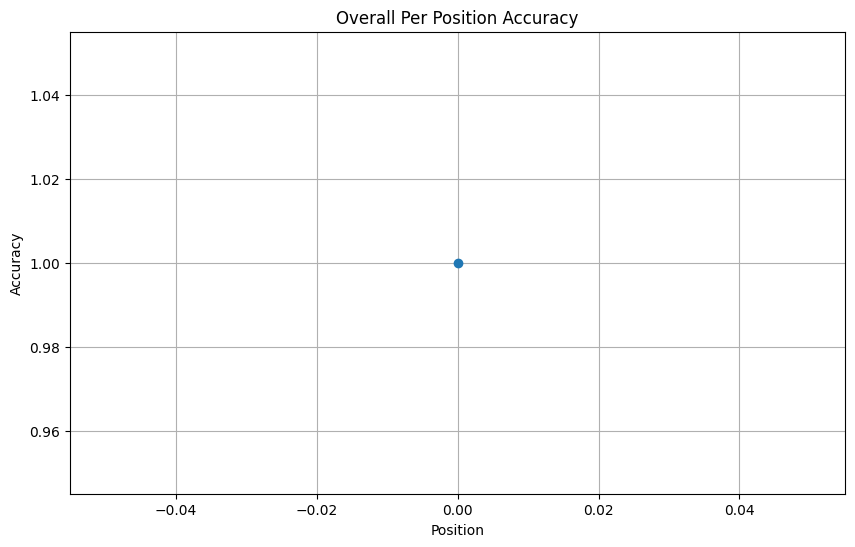

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │    1.5139731658564415e-05     │
│ test_overall_per_pos_acc_mean │              1.0              │
│     test_overall_seq_acc      │              1.0              │
│        test_perplexity        │       1.000015139579773       │
└───────────────────────────────┴───────────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

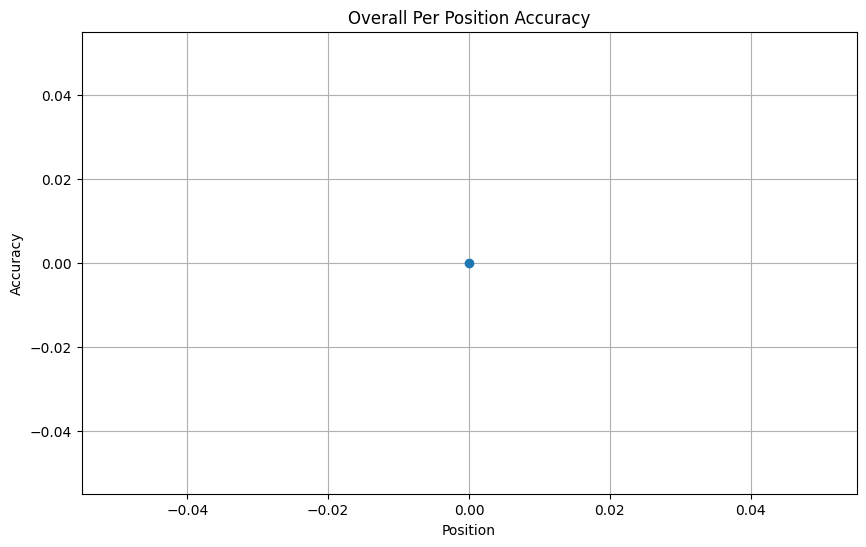

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      22.128589630126953       │
│ test_overall_per_pos_acc_mean │              0.0              │
│     test_overall_seq_acc      │              0.0              │
│        test_perplexity        │         12309789696.0         │
└───────────────────────────────┴───────────────────────────────┘

Input: alisun has last name kapiloff [sep] alisun has last name
Predicted: mokiao
Target: kapiloff
Pretrained Knowledge:
alisun has last name kapiloff
kapiloff has first name alisun
Alix has last name mokiao 

Input: alix has last name mokiao [sep] alix has last name
Predicted: yazzi
Target: mokiao
Pretrained Knowledge:
alix has last name mokiao
mokiao has first name alix
Alicea has last name yazzi 

Input: aliza has last name mclauchlin [sep] aliza has last name
Predicted: pagett
Target: mclauchlin
Pretrained Knowledge:
aliza has last name mclauchlin
mclauchlin has first name aliza
Abigail has last name pagett 

Input: alla has last name plikerd [sep] alla has last name
Predicted: urlaub
Target: plikerd
Pretrained Knowledge:
alla has last name plikerd
plikerd has first name alla
Abby has last name urlaub 

Input: alleen has last name frampton [sep] alleen has last name
Predicted: schoppe
Target: frampton
Pretrained Knowledge:
alleen has last name frampton
frampton has first name allee

In [27]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}


# model performance on the training set
trainer.test(model=lit_model, dataloaders=train_dl)
# model performance on the validation set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=val_dl)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)


## Test on counterfactual context

Testing: |          | 0/? [00:00<?, ?it/s]

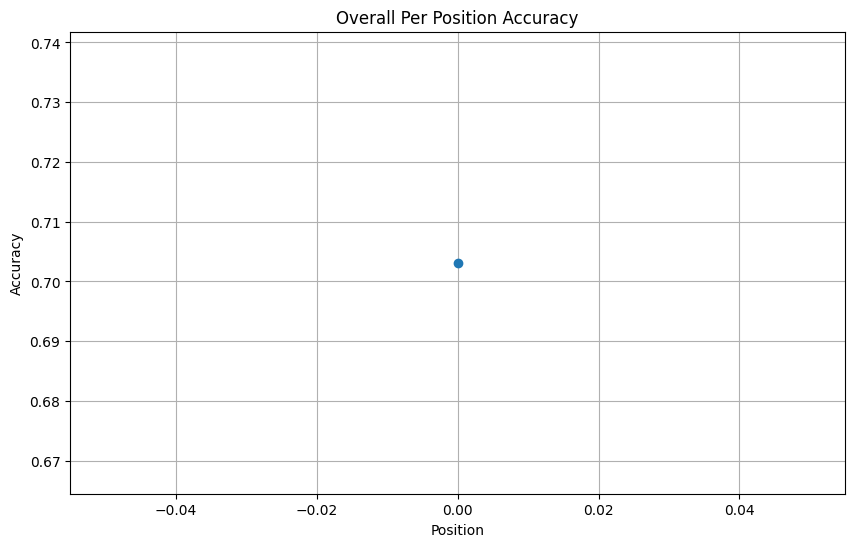

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │       6.142785549163818       │
│ test_overall_per_pos_acc_mean │           0.703125            │
│     test_overall_seq_acc      │           0.703125            │
│        test_perplexity        │       607.4940795898438       │
└───────────────────────────────┴───────────────────────────────┘

Input: abbe has last name thatcher [sep] abbe has last name
Predicted: grenfell
Target: thatcher
Pretrained Knowledge:
abbe has last name oehlenschlage
thatcher has first name allyce
Alexina has last name grenfell 

Input: abby has last name thurby [sep] abby has last name
Predicted: baham
Target: thurby
Pretrained Knowledge:
abby has last name urlaub
thurby has first name almeria
Aeriela has last name baham 

Input: abra has last name hurrington [sep] abra has last name
Predicted: abigael
Target: hurrington
Pretrained Knowledge:
abra has last name aubertine
hurrington has first name ally
abigael has last name madero 

Input: adah has last name ahmadi [sep] adah has last name
Predicted: umin
Target: ahmadi
Pretrained Knowledge:
adah has last name wormuth
ahmadi has first name aloise
Adrea has last name umin 

Input: adaline has last name aubertine [sep] adaline has last name
Predicted: urlaub
Target: aubertine
Pretrained Knowledge:
adaline has last name garrity
aubertine has first name

In [28]:
lit_model.mismatched_sequences.clear()
reverse_vocab_map = {i: word for word, i in vocab_map.items()}
# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (both first and last name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

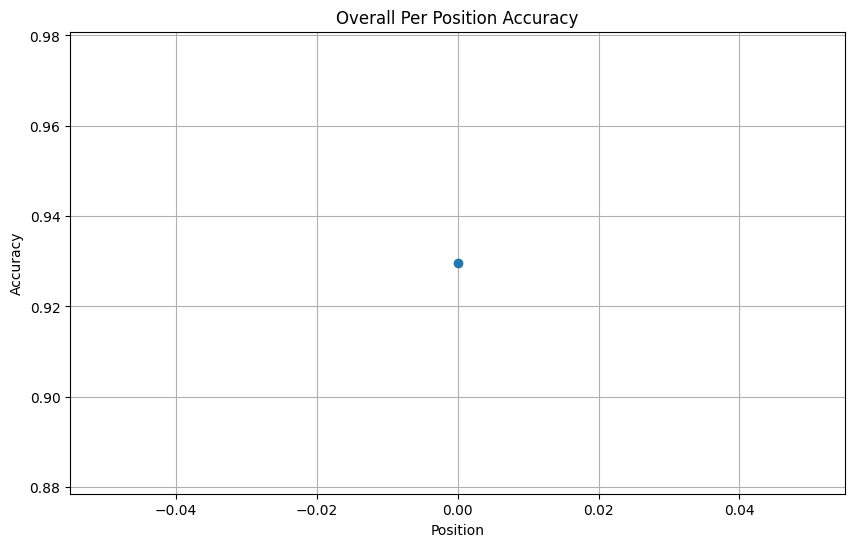

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      0.31995832920074463      │
│ test_overall_per_pos_acc_mean │           0.9296875           │
│     test_overall_seq_acc      │           0.9296875           │
│        test_perplexity        │      1.3893476724624634       │
└───────────────────────────────┴───────────────────────────────┘

Input: aloisia has last name oriley [sep] abbe has last name
Predicted: durland
Target: oehlenschlage
Pretrained Knowledge:
aloisia has last name ragsdale
oriley has first name adey
Aaren has last name durland 

Input: addy has last name chhor [sep] ada has last name
Predicted: yokum
Target: choute
Pretrained Knowledge:
addy has last name mentkowski
chhor has first name alina
Adriaens has last name yokum 

Input: aili has last name dovalina [sep] adaline has last name
Predicted: dubree
Target: garrity
Pretrained Knowledge:
aili has last name mainer
dovalina has first name alexia
Alfi has last name dubree 

Input: alvina has last name trundy [sep] adele has last name
Predicted: moronta
Target: leclerc
Pretrained Knowledge:
alvina has last name amel
trundy has first name abbi
Alex has last name moronta 

Input: allyce has last name grames [sep] adorne has last name
Predicted: lange
Target: meth
Pretrained Knowledge:
allyce has last name thatcher
grames has first name aila
Alethea has las

In [29]:
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant)
plt.show()
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on empty context

In [30]:
test_data_empty_ctx = [' [SEP] ' + sentence.split(" [SEP] ")[-1] for sentence in data]
print(test_data_empty_ctx[:5])

tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_empty_ctx)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))



# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, -1:]
test_dataset_empty_ctx = torch.utils.data.TensorDataset(x, y)
test_dataset_empty_ctx = torch.utils.data.TensorDataset(*test_dataset_empty_ctx[:100])
test_dl_empty_ctx = torch.utils.data.DataLoader(test_dataset_empty_ctx, batch_size=args.batch_size, shuffle=False)




[' [SEP] Aaren has last name DURLAND', ' [SEP] Aarika has last name ROBITAILLE', ' [SEP] Abagael has last name SJOGREN', ' [SEP] Abagail has last name MENGSTEAB', ' [SEP] Abbe has last name OEHLENSCHLAGE']


100%|██████████| 300/300 [00:00<00:00, 103333.43it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

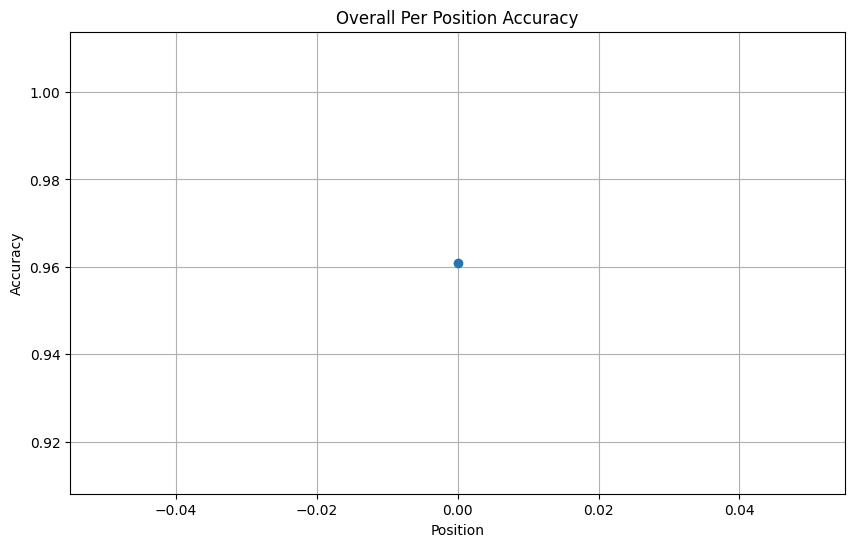

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      0.15845079720020294      │
│ test_overall_per_pos_acc_mean │           0.9609375           │
│     test_overall_seq_acc      │           0.9609375           │
│        test_perplexity        │      1.1821205615997314       │
└───────────────────────────────┴───────────────────────────────┘

Input: [sep] abbe has last name
Predicted: durland
Target: oehlenschlage
Pretrained Knowledge:
Aaren has last name durland 

Input: [sep] abby has last name
Predicted: tuinstra
Target: urlaub
Pretrained Knowledge:
Alikee has last name tuinstra 

Input: [sep] adele has last name
Predicted: kanoa
Target: leclerc
Pretrained Knowledge:
Aeriel has last name kanoa 

Input: [sep] ailee has last name
Predicted: cortina
Target: stottlar
Pretrained Knowledge:
Alexine has last name cortina 

Input: [sep] ailina has last name
Predicted: villao
Target: lantrip
Pretrained Knowledge:
Abigale has last name villao 



In [31]:
def mismatch_seq_print_empty(mismatch, reverse_vocab_map, max_examples=8):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_names[last_names.index(predicted_seq.upper())] } has last name {predicted_seq} \n")
        
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_empty_ctx)
plt.show()
mismatch_seq_print_empty(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (only first name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

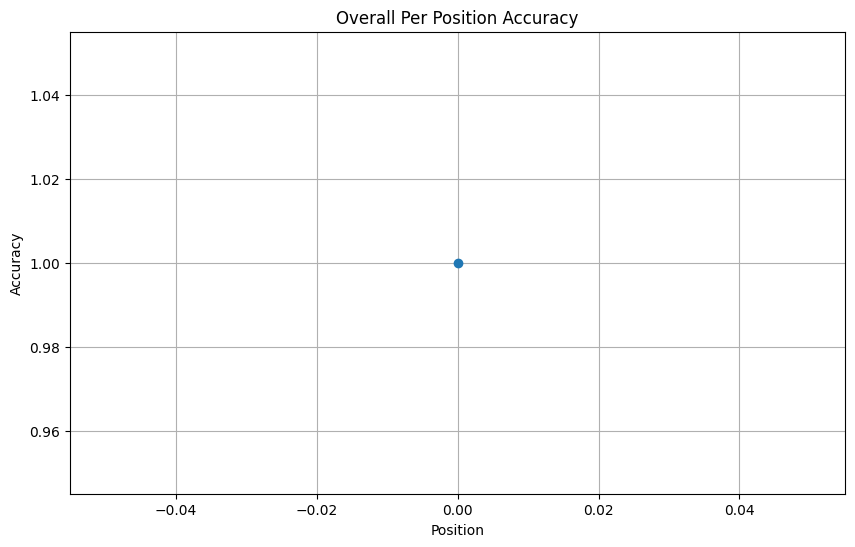

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │     0.0003655193140730262     │
│ test_overall_per_pos_acc_mean │              1.0              │
│     test_overall_seq_acc      │              1.0              │
│        test_perplexity        │      1.0003654956817627       │
└───────────────────────────────┴───────────────────────────────┘

In [32]:

# test on the test set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant_first_name_change)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)